In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.models import *
plt.style.use('ggplot')

In [2]:
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

In [3]:
fake_df['title'].str.replace(r"\(.*\)","")
fake_df['title'].str.replace('WATCH:', '')
true_df.text = true_df.text.apply(clean_text)
fake_df['truth'] = 0
true_df['truth'] = 1
all_news_df = pd.concat([fake_df, true_df])
all_news_df.title = all_news_df.title.apply(clean_titles)

In [4]:
X_train, X_test, y_train, y_test = get_X_y_splits(all_news_df, 'title')

In [5]:
pa_model = passive_aggressive_model(X_train, y_train)
pa_model.score(X_test, y_test)

0.9524276169265034

In [6]:
cv = CountVectorizer(stop_words='english', max_features=1000, ngram_range=(1,2))
counts = cv.fit_transform(X_train).sum(axis=0)
features = cv.get_feature_names()
counts_df = pd.DataFrame(index=features, data=counts.T, columns=['counts'])
counts_df.sort_values('counts', ascending=False, inplace=True)

In [7]:
bag = pa_model.best_estimator_.named_steps.vect.get_feature_names()
pa_coefs = pa_model.best_estimator_.named_steps.clf.coef_
freq_df = pd.DataFrame(index=bag, data={'coefs': pa_coefs[0]})
freq_df = freq_df.iloc[(-freq_df['coefs'].abs()).argsort()]

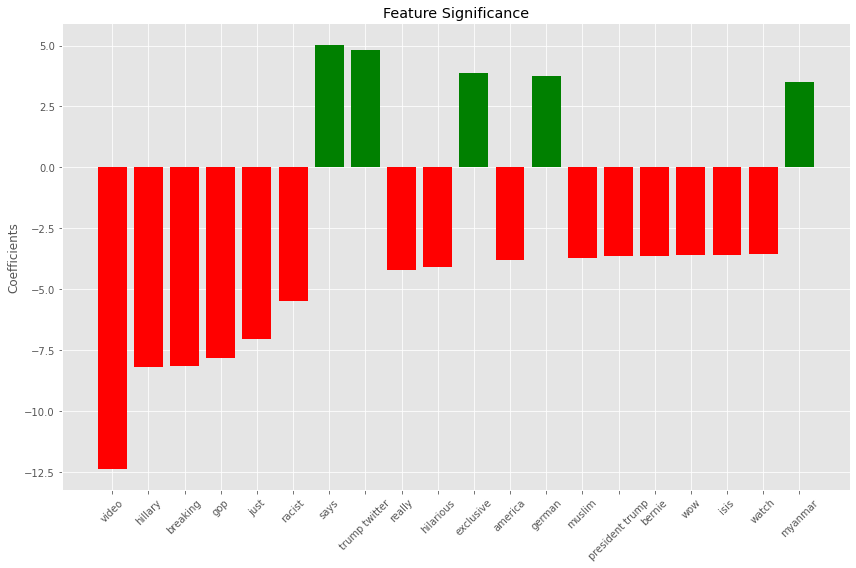

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
def plot_feature_significance(model, fig, ax, col=None):
    bag = model.best_estimator_.named_steps.vect.get_feature_names()
    model_coefs = model.best_estimator_.named_steps.clf.coef_
    freq_df = pd.DataFrame(index=bag, data={'coefs': model_coefs[0]})
    freq_df = freq_df.iloc[(-freq_df['coefs'].abs()).argsort()]
    ax.bar(freq_df.index[:20], freq_df['coefs'][:20].values, color=(freq_df['coefs'][:20] > 0).map({True:'green',False:'red'}))
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(f'Feature Significance {col}')
    ax.set_ylabel('Coefficients')
    fig.tight_layout()
    # fig.savefig(f'images/feature_correlation_{col}')
plot_feature_significance(pa_model, fig, ax)

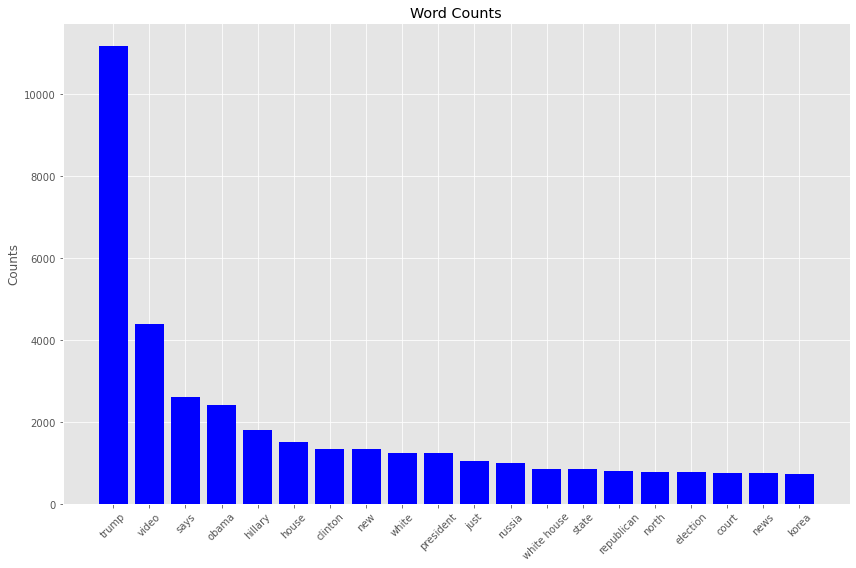

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
def plot_word_counts(X_train, fig, ax, col=None):
    cv = CountVectorizer(stop_words='english', max_features=1000, ngram_range=(1,2))
    counts = cv.fit_transform(X_train).sum(axis=0)
    features = cv.get_feature_names()
    counts_df = pd.DataFrame(index=features, data=counts.T, columns=['counts'])
    counts_df.sort_values('counts', ascending=False, inplace=True)
    ax.bar(counts_df.index[:20], counts_df['counts'][:20].values, color='blue')
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(f'Word Counts {col}')
    ax.set_ylabel('Counts')
    fig.tight_layout()
    # fig.savefig(f'images/word_counts_{col}')
plot_word_counts(X_train, fig, ax, col='Title')

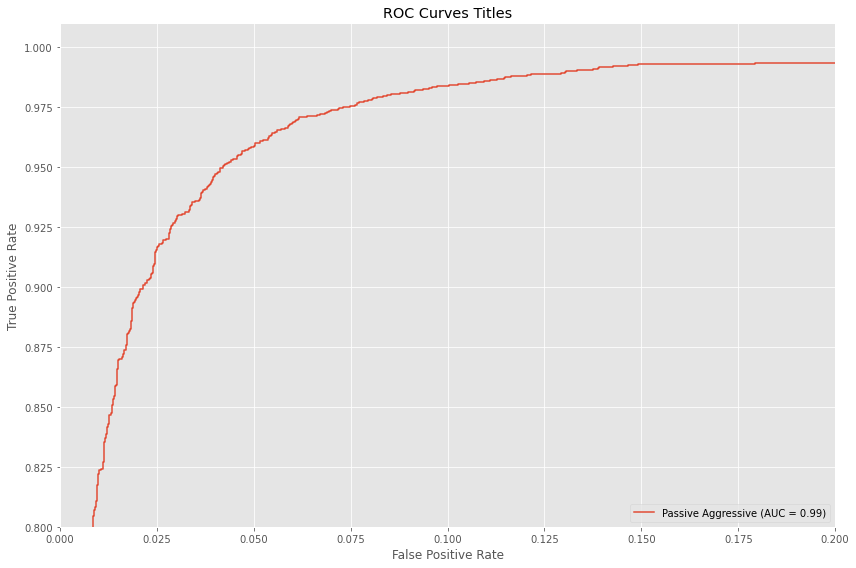

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
models = [pa_model]
titles = ['Passive Aggressive']
def plot_all_roc_curves(models, titles, fig, ax, col=None):
    for model, title in zip(models,titles):
        plot_roc_curve(model, X_test, y_test, name=f'{title}', ax=ax)
    ax.set_ylim(.8,1.01)
    ax.set_xlim(0,.2)
    ax.set_title(f'ROC Curves {col}')
    fig.tight_layout()
    # fig.savefig(f'images/roc_curves_{col}')
plot_all_roc_curves(models, titles, fig, ax, col='Titles')